In [1]:
import numpy as np
from astropy.io import fits
from astropy.io import ascii
from astropy.table import Column, Table
from astropy import units as u
from astropy import constants as const
from astropy import wcs
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import curve_fit
from scipy.integrate import quad

In [11]:
%matplotlib inline

In [2]:
#define constants
h=6.62607e-34 #Planck constant
k=1.38065e-23 #Boltzmann constant
m_H=1.6726e-24 #Proton mass, in g
m_sun=const.M_sun
d=7.07 * u.kpc #distance, 7.07 kpc (Roman-Duval 2009)
k_600=0.0333#k_v in 600 GHz, consider GDR as 100, in cm^2/g (from column 5 of table 1 in Ossenkopf & Henning 1994, often referred to as OH5)
lamda_0=500 #wavelength of v_0, in micron
nu_0=600 * 10**9
mu=2.8 #atomic mass unit of H2
beta=2 #consider beta as 2
c=2.998e8 #light speed


#define SED function, input are lamda(in micronmeter), T and N(in g/cm^2), output is intensity(in MJy/sr)
def SED(lamda,T,N):
	nu=c/(lamda*1e-6)
	k_nu=k_600*(lamda_0/lamda)**beta
	return 2*1e20*h*nu**3/c**2*(1-np.exp(-k_nu*N))/(np.exp(h*nu/k/T)-1)
#input: nu(in Hz), T(in K), N(in g/cm^2)
#output:intensity(in cgs: g/s^2)
def SED2(nu,T,N):
	k_nu=k_600*(nu/nu_0)**beta
	return 2*1e20*h*nu**3/c**2*(1-np.exp(-k_nu*N))/(np.exp(h*nu/k/T)-1)

In [3]:
jps_file='/Users/shjiao/desktop/check/m31_850/test_file.csv'
jps_cat=ascii.read(jps_file)
jps_cat

col1,col2,col3,col4,col5,col6,col7,col8,col9,col10
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0,0.0,5008.0,inf,0.0,0.0,0.0,0.0,nan,nan
1,0.0,688.0,inf,0.0,0.0,0.0,0.0,nan,nan
2,118.427540631,256.0,0.00340927216244,6.79670086323,4.00089006945,-138.271156089,5.21467669072,114.944341465,47.3837124647
3,0.0,4976.0,inf,0.0,0.0,0.0,0.0,nan,nan
4,232.8266423,640.0,0.0103742648081,7.70044246262,6.94255068752,63.200316467,7.31168326126,179.05631807,53.7488529773
5,0.0,608.0,inf,0.0,0.0,0.0,0.0,nan,nan
6,81.9623824529,208.0,0.00258433621473,5.64250070326,3.33537766559,88.052274188,4.33818750445,105.924437502,57.8521534324
7,102.077913629,256.0,0.00392884958456,5.17214783054,4.53171845011,122.283936143,4.84135494984,82.7447455845,62.718459884
8,112.176800977,288.0,0.00408223459907,5.95375301155,4.32627678302,94.5407930892,5.07519294468,201.696184771,64.4500600794


In [4]:
im_160='/Users/shjiao/desktop/check/sed/data/regird/pacs160.sm.fitshcongrid.fits'
im_250='/Users/shjiao/desktop/check/sed/data/regird/spire250.conv.fitshcongrid.fits'
im_450='/Users/shjiao/desktop/check/sed/data/regird/combined450.sm.fitshcongrid.fits'
im_850='/Users/shjiao/desktop/check/sed/data/regird/combined850.sm.fits'

#open the input file
hdu_160=fits.open(im_160)
hdu_250=fits.open(im_250)
hdu_450=fits.open(im_450)
hdu_850=fits.open(im_850)

#initialize
name=[]
glon=[]
glat=[]
major=[]
minor=[]
PA=[]
r_eq=[]
SNR_850=[]
T_dust=[]
N_H2=[]
n_H2=[]
sigma=[]
mass=[]
luminosity=[]
l_m=[]

In [7]:
for i in range(len(jps_cat)):
    if jps_cat['col2'][i]>0.0:
        name.append(jps_cat['col1'][i])
        glon.append('%.3f' % jps_cat['col9'][i])
        glat.append('%.3f' % jps_cat['col10'][i])
        major.append(jps_cat['col5'][i])
        minor.append(jps_cat['col6'][i])
        PA.append(jps_cat['col7'][i])
        r_pc=np.sqrt(jps_cat['col5'][i]*jps_cat['col6'][i]) / 3600.0 / 180*np.pi * d.value*1000
        r_eq.append('%.2f' % r_pc)
        #calcular ellipse size in 14"
        maj_14=major[i]
        min_14=minor[i]
    
        a=maj_14 / 4.
        b=min_14 / 4.
        pa=PA[i] * u.deg
    
        w=wcs.WCS(hdu_850[0].header)
        
        #find pixels that located in the source area
        center_world=np.array([[jps_cat['col9'][i],jps_cat['col10'][i]]])
        center_pixel=np.array([[jps_cat['col9'][i],jps_cat['col10'][i]]])
        x0,y0=center_pixel[0][0],center_pixel[0][1]
    
        y,x=np.indices(hdu_160[0].data.shape)
        inside = ( (((y-y0)*np.sin(pa.cgs.value)+(x-x0)*np.cos(pa.cgs.value))/b)**2 + (((y-y0)*np.cos(pa.cgs.value)-(x-x0)*np.sin(pa.cgs.value))/a)**2 <1 )
    
        #average intensity of the source
        inside_160=hdu_160[0].data[inside].flatten()
        flux_160=np.mean(inside_160[inside_160==inside_160]) * u.Jy / (4. * u.arcsec)**2
        flux_160=flux_160.to_value(u.MJy / u.sr)
        
        y,x=np.indices(hdu_250[0].data.shape)
        inside = ( (((y-y0)*np.sin(pa.cgs.value)+(x-x0)*np.cos(pa.cgs.value))/b)**2 + (((y-y0)*np.cos(pa.cgs.value)-(x-x0)*np.sin(pa.cgs.value))/a)**2 <1 )
    
        #average intensity of the source
        inside_250=hdu_250[0].data[inside].flatten()
        flux_250=np.mean(inside_250[inside_250==inside_250])
        
        y,x=np.indices(hdu_450[0].data.shape)
        inside = ( (((y-y0)*np.sin(pa.cgs.value)+(x-x0)*np.cos(pa.cgs.value))/b)**2 + (((y-y0)*np.cos(pa.cgs.value)-(x-x0)*np.sin(pa.cgs.value))/a)**2 <1 )
    
        #average intensity of the source
        inside_450=hdu_450[0].data[inside].flatten()
        flux_450=np.mean(inside_450[inside_450==inside_450])*u.Jy / (225 * u.arcsec**2)
        flux_450=flux_450.to_value(u.MJy/u.sr)
        
        y,x=np.indices(hdu_850[0].data.shape)
        inside = ( (((y-y0)*np.sin(pa.cgs.value)+(x-x0)*np.cos(pa.cgs.value))/b)**2 + (((y-y0)*np.cos(pa.cgs.value)-(x-x0)*np.sin(pa.cgs.value))/a)**2 <1 )
    
        #average intensity of the source
        #change the unit from mJy/beam to MJy/sr
        inside_850=hdu_850[0].data[inside].flatten()
        flux_850=np.mean(inside_850[inside_850==inside_850])*u.Jy / (225 * u.arcsec**2)
        flux_850=flux_850.to_value(u.MJy/u.sr)
        
        #fit the SED of JPS core
        xdata=[160,250,450,850]
        ydata=[flux_160,flux_250,flux_450,flux_850]
        yerr=[flux_160*0.2,flux_250*0.2,flux_450*0.2,flux_850*0.2]
    
        popt,pcov=curve_fit(SED,xdata,ydata,p0=[15,0.1])
    
        #derive the physical properties
        T_dust.append('%.2f' % popt[0])
        sigma.append('%.2f' % popt[1])
        N_H2.append('%.2f' % (popt[1]/mu/m_H / (1*10**20)))
    

/Users/shjiao/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/scipy/optimize/minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [14]:
name_1=[]
glon_1=[]
glat_1=[]
major_1=[]
minor_1=[]
PA_1=[]
r_eq_1=[]

In [15]:
for i in range(len(jps_cat)):
    if jps_cat['col2'][i]>0.0:
        name_1.append(i)
        glon_1.append('%.3f' % jps_cat['col9'][i])
        glat_1.append('%.3f' % jps_cat['col10'][i])
        major_1.append(jps_cat['col5'][i])
        minor_1.append(jps_cat['col6'][i])
        PA_1.append(jps_cat['col7'][i])
        r_pc=np.sqrt(jps_cat['col5'][i]*jps_cat['col6'][i]) / 3600.0 / 180*np.pi * d.value*1000
        r_eq_1.append('%.2f' % r_pc)
        #calcular ellipse size in 14"

In [19]:
#export the catalogue
name=Column(name_1,name='JPS_name')
glon=Column(glon_1,name='l\_peak')
glat=Column(glat_1,name='b\_peak')
major=Column(major_1,name='maj')
minor=Column(minor_1,name='min')
PA=Column(PA_1,name='PA',unit='\degr')
r_eq=Column(r_eq_1,name='r\_eq')
T_dust=Column(T_dust,name='T\_dust')
N_H2=Column(N_H2,name='N\_H2',unit=r'$10^{22}\,cm^{-2}$')

    
table=Table([name,glon,glat,major,minor,PA,r_eq,T_dust,N_H2])
table.write('/Users/shjiao/desktop/check/photometry.csv',format='csv',overwrite=True)
table.write('/Users/shjiao/desktop/check/photometry.tex',format='latex',overwrite=True)

In [62]:
jps_file='/Users/shjiao/desktop/check/photometry_sec.csv'
jps_cat=ascii.read(jps_file)
jps_cat

JPS_name,l\_peak,b\_peak,maj,min,PA,r\_eq,T\_dust,N\_H2
int64,float64,float64,float64,float64,float64,float64,float64,float64
4,179.056,53.749,7.70044246262,6.94255068752,63.200316467,0.25,20.76,3.62
8,201.696,64.45,5.95375301155,4.32627678302,94.5407930892,0.17,18.22,5.81
10,199.577,70.764,7.54927288705,3.37155864657,142.19574833,0.17,18.53,4.91
12,195.808,78.733,11.7953278438,4.62990749838,123.576081078,0.25,19.06,4.05
13,165.953,80.154,9.25263639902,5.30588705213,107.143705769,0.24,22.63,3.58
15,156.546,86.837,10.3803932976,7.20392004397,87.9391137292,0.3,22.78,4.35
17,179.011,94.448,11.2645126435,4.1496263399,115.79381857,0.23,19.69,4.71
18,116.106,97.109,4.40395098573,4.01983850326,-159.283838084,0.14,25.72,0.89
19,110.279,100.898,4.00277755211,3.46645449958,47.2388579459,0.13,22.39,1.24


In [63]:
td=[]
nh2=[]
for i in range(len(jps_cat)):
    td.append(jps_cat['T\_dust'][i])
    nh2.append(jps_cat['N\_H2'][i])
    

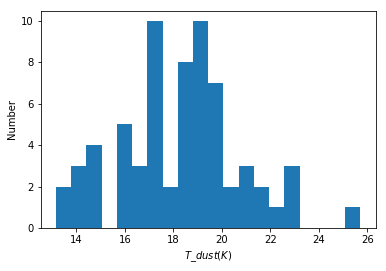

In [64]:
# the histogram of the data
plt.hist(td,20)


plt.xlabel(r'$T\_dust (K)$')
plt.ylabel('Number')
#plt.axis([40, 160, 0, 0.03])
plt.show()

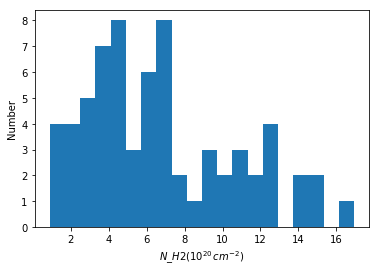

In [60]:
# the histogram of the data
plt.hist(nh2,20)


plt.xlabel(r'$N\_H2 (10^{20}\,cm^{-2})$')
plt.ylabel('Number')
#plt.axis([40, 160, 0, 0.03])
plt.show()

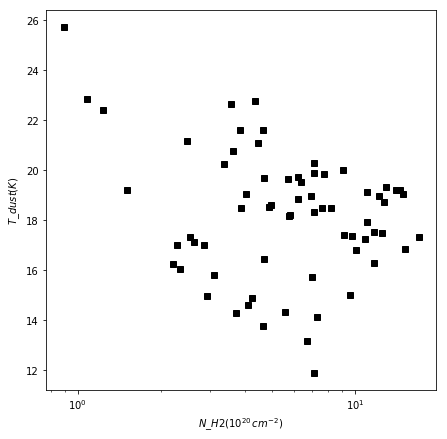

In [61]:
#plot the fit result
#build the frame of the graph
fig=plt.figure(figsize=(7,7))
#plt.xlim(10,1000)
#plt.ylim(10,200000)
#plt.yscale('log')
plt.ylabel(r'$T\_dust (K)$')
plt.xlabel(r'$N\_H2 (10^{20}\,cm^{-2})$')
plt.xscale('log')

#plot the data and function
plt.plot(nh2,td,'ks')


In [68]:
np.mean(td)

18.308333333333337

In [69]:
np.mean(nh2)

6.7303030303030313